In [4]:
import tifffile as tiff
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
def read_and_crop(cellbound,i):
    return tiff.imread('../../data/raw/Vizgen/test/mosaic_{}_z{}.tif'.format(cellbound,i))[5800:10300,6100:10400]


def show_marker_images(marker):

    imgs = [read_and_crop(marker,i) for i in range(6)]

    # Create subplots
    fig, axes = plt.subplots(1, 6, figsize=(16, 7))

    # Flatten the axes array for easy indexing
    axes = axes.ravel()

    # Show images
    for i, img in enumerate(imgs):
        axes[i].imshow(img)
        axes[i].set_title(marker + ' ' + str(i))
        axes[i].axis("off")

    plt.show()

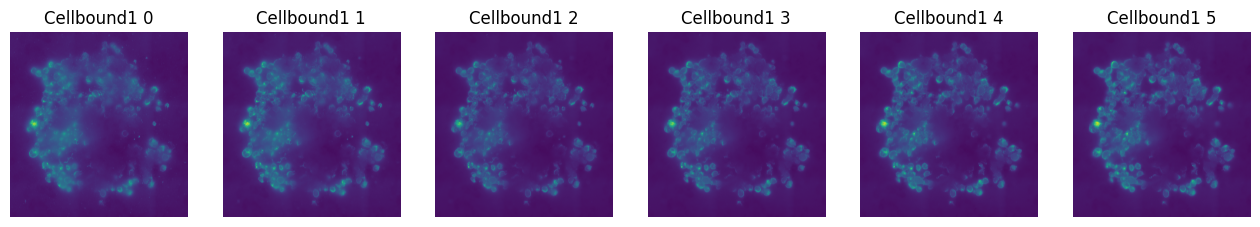

In [14]:
markers = ['Cellbound1','Cellbound2','Cellbound3','GFP','DAPI','PolyT']

show_marker_images(markers[0])

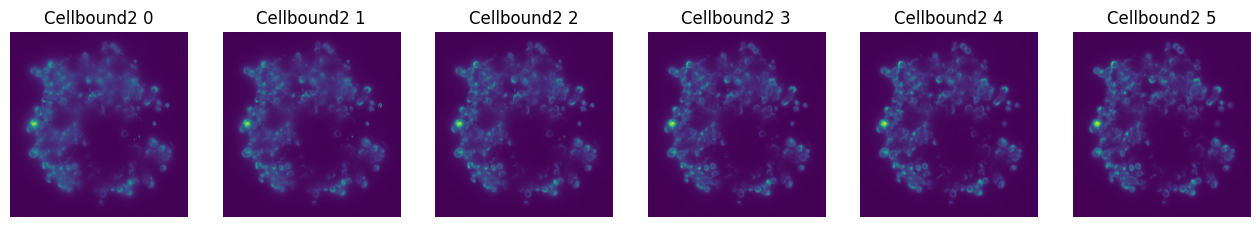

In [15]:
show_marker_images(markers[1])

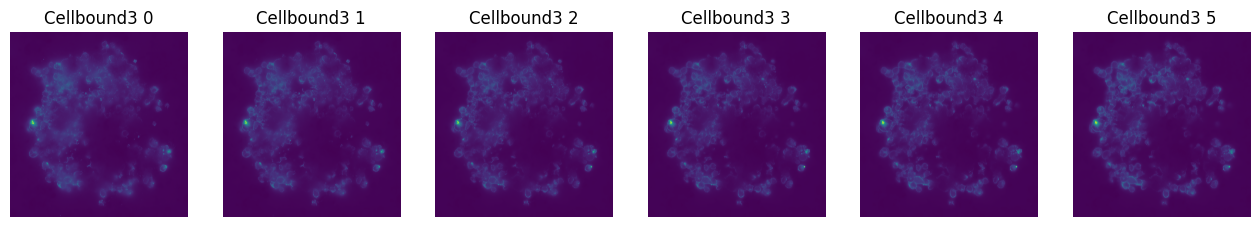

In [16]:
show_marker_images(markers[2])

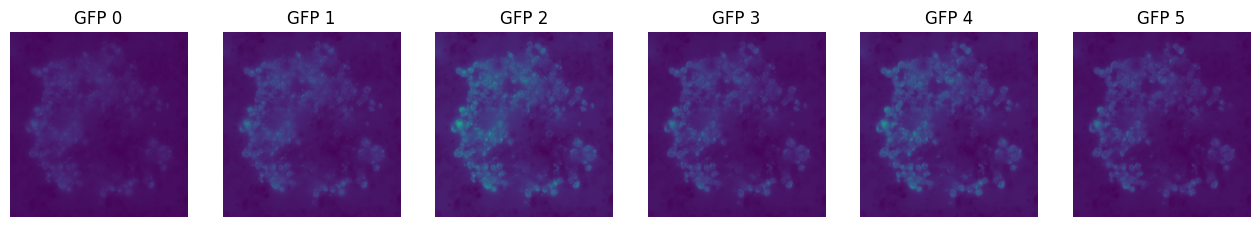

In [17]:
show_marker_images(markers[3])

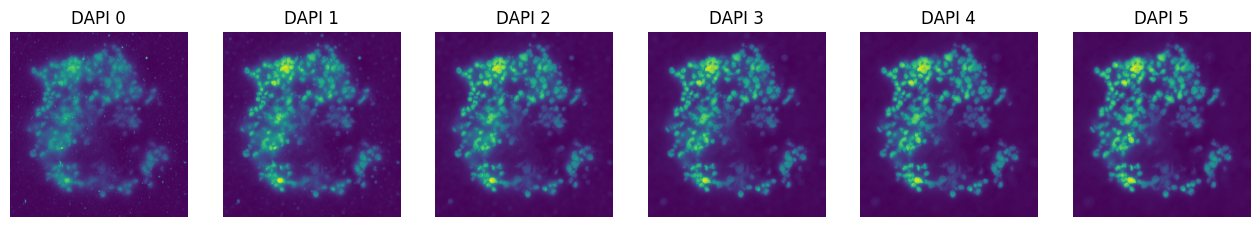

In [18]:
show_marker_images(markers[4])

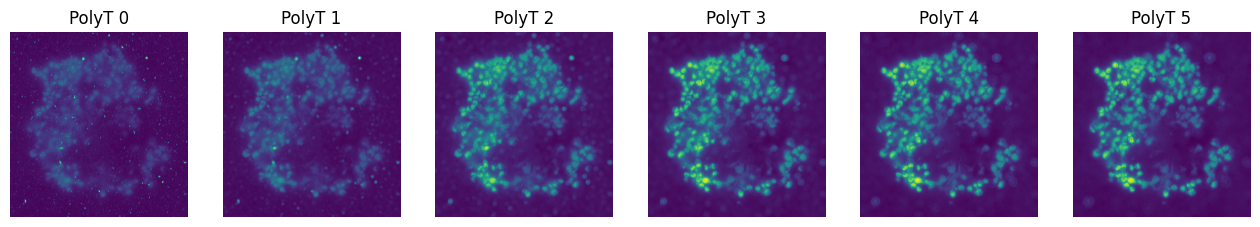

In [19]:
show_marker_images(markers[5])

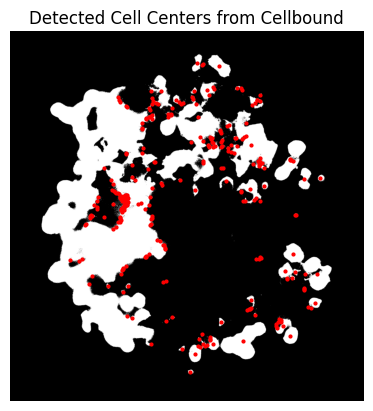

In [26]:
import cv2
import numpy as np
from skimage.measure import label, regionprops

img = read_and_crop('Cellbound1',5)

blurred = cv2.GaussianBlur(img, (3, 3), 0) # Denoising
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) # Threshold

# remove small noises
kernel = np.ones((3, 3), np.uint8)
clean = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

# Label each cell
labeled = label(clean)
props = regionprops(labeled)

fig, ax = plt.subplots()
ax.imshow(binary, cmap='gray')

for cell in props:
    y, x = cell.centroid
    ax.plot(x, y, 'ro', markersize=2)

plt.title("Detected Cell Centers from Cellbound")
plt.axis('off')
plt.show()

In [11]:
from cellpose import models
from cellpose.io import imread
import matplotlib.pyplot as plt

# Load image (grayscale)
img = read_and_crop('Cellbound1',5)  # Make sure it's 2D or 3D with channels last

# Initialize Cellpose model (cyto = membrane/cell marker)
model = models.Cellpose(model_type='cyto')

# Run segmentation
masks, flows, styles, diams = model.eval(img, diameter=40, channels=[0, 0])

(-0.5, 4299.5, 4499.5, -0.5)

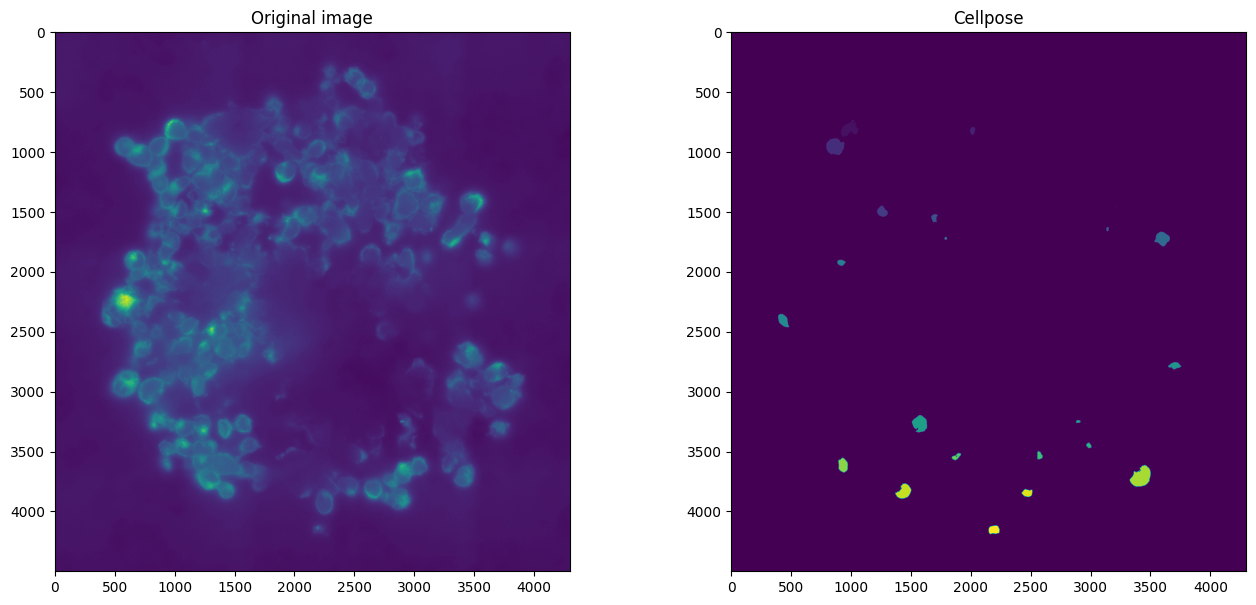

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

axes = axes.ravel()

axes[0].imshow(img)
axes[0].set_title('Original image')
axes[0].axis("on")

axes[1].imshow(masks)
axes[1].set_title('Cellpose')
axes[1].axis("on")


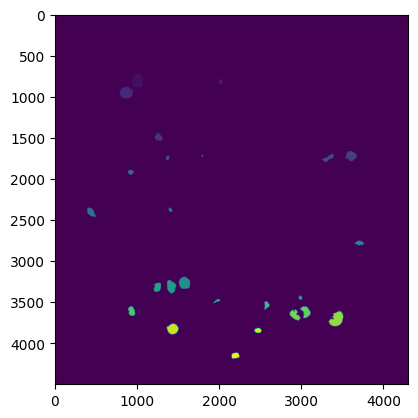